# 割引クーポンキャンペーンの効果最大化

## 1. 問題設定
予算とダイレクトメール送付率の制約条件のもとで来客数を最大化する問題を考える

#### 1-1. 前提条件  
 ‐ 予算は100万円
 - 雑貨店の会員数は5000人
 - 全会員に対して次の3種類のいずれかのパターンのダイレクトメールを送付する
   1. セールのチラシのみ
   2. セールのチラシと1000円のクーポン
   3. セールのチラシと2000円のクーポン
 - 継続的な施策実施のため、次回以降の割引クーポンキャンペーンで利用する来店率のデータを一定数取得するように、「来店傾向を基に会員をグルーピングしたセグメントごとに10％以上ずるダイレクトメールを送付する」という条件を付ける
 - クーポン付与による来客増加数を最大化したい
 - 会員情報として下記がある
   - 年齢区分
   - 昨年度の来店回数区分
 - 一部会員のアンケート結果を基に、年齢区分と昨年度来店回数区分の組で定義される会員のセグメントに対して、各パターンのダイレクトメールを受け取った際に来店する確率が推定される
 
#### 1-2. 解くべき最適化問題の要件
 - 要件１：各会員に対してどのパターンのダイレクトメールを送付するか決定
 - 要件２：送付するダイレクトメールはどれか1パターン
 - 要件３：来客増加数を最大化する
 - 要件４：会員の予算消費期待値の合計は100万円以下（予算オーバーを防ぐ）
 - 要件５：各パターンのダイレクトメールをそれぞれのセグメントに属する会員の10％以上に送付

## 2. 必要ライブラリのインポートとデータの理解

In [2]:
import numpy as np
import pandas as pd
import pulp
import seaborn as sns
import matplotlib.pyplot as plt

#### 2-1. 顧客情報

In [3]:
customer_df = pd.read_csv("./data/customers.csv")
customer_df

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0
...,...,...,...
4995,4996,age50~,freq0
4996,4997,age50~,freq0
4997,4998,age35~49,freq1
4998,4999,age50~,freq1


In [4]:
customer_df.describe(include= 'all' )

,customer_id,age_cat,freq_cat
count,5000.000000,5000,5000
unique,NaN,4,4
top,NaN,age35~49,freq0
freq,NaN,2000,2000
mean,2500.500000,NaN,NaN
std,1443.520003,NaN,NaN
min,1.000000,NaN,NaN
25%,1250.750000,NaN,NaN
50%,2500.500000,NaN,NaN
75%,3750.250000,NaN,NaN


In [5]:
customer_df.dtypes

customer_id     int64
age_cat        object
freq_cat       object
dtype: object

In [6]:
customer_df["age_cat"].unique()

array(['age20~34', 'age35~49', 'age~19', 'age50~'], dtype=object)

In [7]:
customer_df["freq_cat"].unique()

array(['freq2', 'freq0', 'freq1', 'freq3~'], dtype=object)

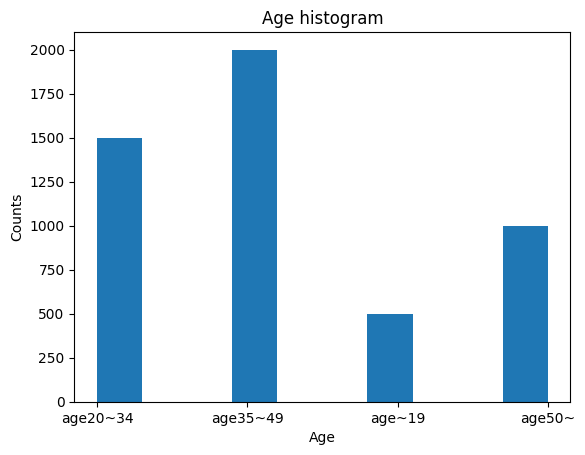

In [8]:
plt.hist(customer_df["age_cat"])
plt.xlabel("Age")
plt.ylabel("Counts")
plt.title("Age histogram")
plt.show()

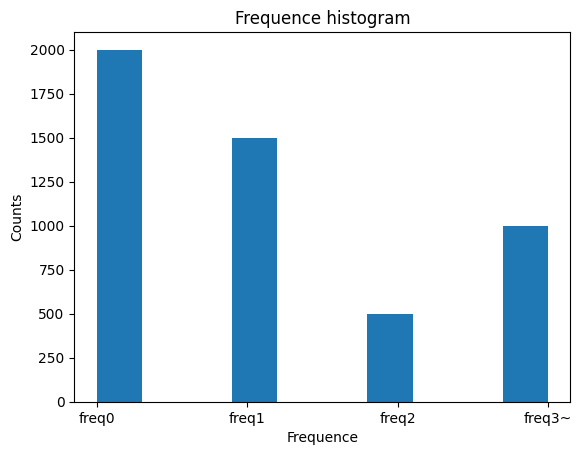

In [9]:
plt.hist(customer_df["freq_cat"].sort_values(ascending=True))
plt.xlabel("Frequence")
plt.ylabel("Counts")
plt.title("Frequence histogram")
plt.show()

In [10]:
customer_pivot_df = pd.pivot_table(data=customer_df, values="customer_id", columns="freq_cat", index="age_cat", aggfunc="count")
customer_pivot_df

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200
age~19,200,150,50,100


In [11]:
customer_pivot_df = customer_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
customer_pivot_df

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age~19,200,150,50,100
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200


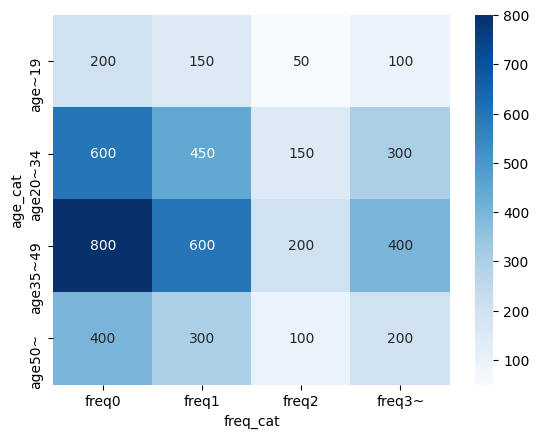

In [12]:
sns.heatmap(customer_pivot_df, annot=True, fmt="d", cmap="Blues");

#### 2-2. 来店確率

In [13]:
visit_probability_df = pd.read_csv("./data/visit_probability.csv")
visit_probability_df

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


In [14]:
visit_probability_df.shape

(16, 6)

In [15]:
visit_probability_df.describe(include="all")

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
count,16,16,16.000000,16.000000,16.000000,16.000000
unique,4,4,NaN,NaN,NaN,NaN
top,age~19,freq3~,NaN,NaN,NaN,NaN
freq,4,4,NaN,NaN,NaN,NaN
mean,NaN,NaN,8.500000,0.267500,0.366875,0.673750
std,NaN,NaN,4.760952,0.135917,0.158313,0.230387
min,NaN,NaN,1.000000,0.070000,0.120000,0.290000
25%,NaN,NaN,4.750000,0.185000,0.267500,0.527500
50%,NaN,NaN,8.500000,0.280000,0.405000,0.730000
75%,NaN,NaN,12.250000,0.350000,0.460000,0.865000


In [16]:
visit_probability_df.columns

Index(['age_cat', 'freq_cat', 'segment_id', 'prob_dm1', 'prob_dm2',
       'prob_dm3'],
      dtype='object')

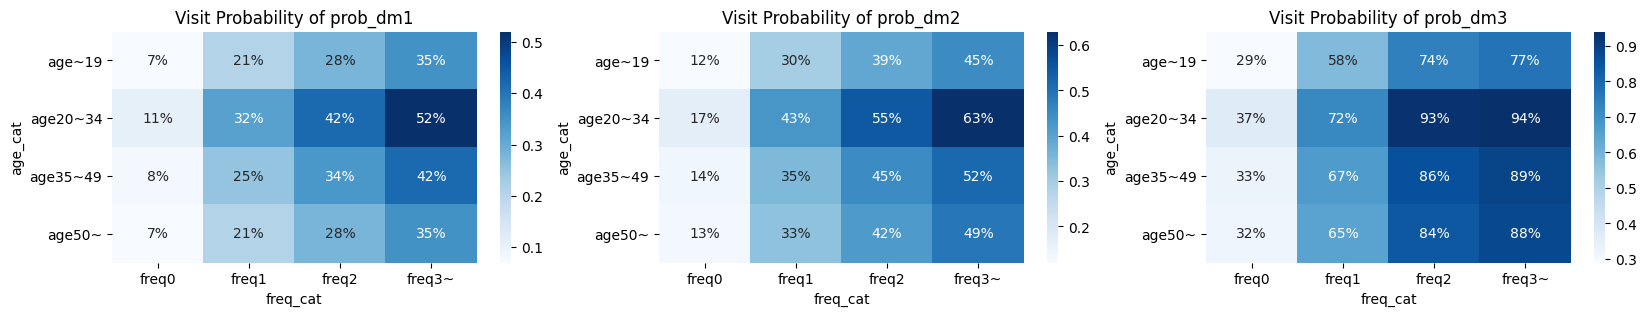

In [17]:
fig,ax = plt.subplots(1,3, figsize=(20,3))
for i, p in enumerate(['prob_dm1', 'prob_dm2', 'prob_dm3']):
    probability_pivot_df = pd.pivot_table(data=visit_probability_df, values=p, columns="freq_cat", index="age_cat")
    probability_pivot_df = probability_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(probability_pivot_df, annot=True, fmt=".0%", cmap="Blues", ax=ax[i])
    ax[i].set_title(f"Visit Probability of {p}")

## 3. 数理モデリングの実装
#### 3-1. 会員個別送付モデル
会員一人一人に対してどのパターンのダイレクトメールを送付するか決定する。送るか(1)送らないか(0)を表す離散変数を使ってモデルを表現する

In [18]:
problem = pulp.LpProblem("DiscountCouponProblem1", sense=pulp.LpMaximize)

#### 3-1-1. 最適化要件１：各会員に対してどのパターンのダイレクトメールを送付するか決定
 - 会員のリスト$I$
 - ダイレクトメールのパターンのリスト$M = \{1,2,3\}$
   - 1:セールのチラシのみ
   - 2:セールのチラシと1000円のクーポン
   - 3:セールのチラシと2000円のクーポン
 - 決定変数：会員$i (\in I)$に対してダイレクトメールのパターン$m (\in M)$を送付する場合に1, しない場合に0を取る変数
   - $x_{i,m} \in \{0,1\} (i \in I, m \in M)$

In [19]:
#会員IDのリスト
I_list = customer_df["customer_id"].to_list()
print(f"num of I list:{len(I_list)}")

num of I list:5000


In [20]:
#ダイレクトメールのパターンのリスト
M_list = [1, 2, 3]

In [21]:
#決定変数の定義
xim = {}
for i in I_list:
    for m in M_list:
        xim[i,m] = pulp.LpVariable(name=f"xim({i},{m})", cat="Binary")
print(f"num of xim:{len(xim)}")

num of xim:15000


#### 3-1-2. 最適化要件２：各会員に対して送付するダイレクトメールはいずれか1パターン
 - $\sum_{m \in M} x_{i,m} = 1 $

In [22]:
for i in I_list:
    problem += pulp.lpSum(xim[i,m] for m in M_list) == 1

#### 3-1-3. 最適化要件３：クーポン付与による来客増加数を最大化
 - 会員$i$に対してパターン$m$のダイレクトメールを送付した時の来店率　$P_{im} \in [0,1] \ \ (i\in I, m \in M)$
 - $Max [ \sum_{i\in I} \sum_{m \in M} (P_{im} - P_{i1})x_{im}]$

In [23]:
keys = ["age_cat", "freq_cat"]
customer_prob_df = pd.merge(customer_df, visit_probability_df, on=keys)
customer_prob_df

,customer_id,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,1,age20~34,freq2,7,0.42,0.55,0.93
1,199,age20~34,freq2,7,0.42,0.55,0.93
2,200,age20~34,freq2,7,0.42,0.55,0.93
3,255,age20~34,freq2,7,0.42,0.55,0.93
4,269,age20~34,freq2,7,0.42,0.55,0.93
...,...,...,...,...,...,...,...
4995,4474,age~19,freq2,3,0.28,0.39,0.74
4996,4596,age~19,freq2,3,0.28,0.39,0.74
4997,4720,age~19,freq2,3,0.28,0.39,0.74
4998,4910,age~19,freq2,3,0.28,0.39,0.74


melt関数を使って、横持ちの状態のデータフレームを1つの行に1つのパターンの来店率のみを格納した縦持ちのデータフレームに変換する

In [24]:
customer_prob_ver_df = customer_prob_df.rename(columns={"prob_dm1":1, "prob_dm2":2, "prob_dm3":3})
customer_prob_ver_df = customer_prob_ver_df.melt(id_vars=["customer_id"], value_vars=[1,2,3], var_name="dm", value_name="prob")
customer_prob_ver_df

,customer_id,dm,prob
0,1,1,0.42
1,199,1,0.42
2,200,1,0.42
3,255,1,0.42
4,269,1,0.42
...,...,...,...
14995,4474,3,0.74
14996,4596,3,0.74
14997,4720,3,0.74
14998,4910,3,0.74


In [25]:
P_im = customer_prob_ver_df.set_index(["customer_id", "dm"])["prob"].to_dict()
# {(1, 1): 0.42,
#  (199, 1): 0.42,
#  (200, 1): 0.42,...}

In [26]:
P_im[1,1]

0.42

In [27]:
P_im[4474,3]

0.74

In [28]:
#目的関数の実装
# 目的関数の計算では(Pi1-Pi1)=0のためインデックス1は不要
problem += pulp.lpSum((P_im[i,m] - P_im[i,1]) * xim[i,m] for i in I_list for m in [2,3])

#### 3-1-4. 最適化要件４：会員の予算消費期待値は100万円以下
 - パターン$m$のダイレクトメールに付与するクーポンの金額　$C_{m} \in \{0,1000,2000\} \ \ (m \in M)$
 - $\sum_{i\in I} \sum_{m \in M} C_{m}P_{im}x_{im} <= 1000000$

In [29]:
Cm = {1:0, 2:1000, 3:2000}
#クーポンを付与しない場合は0のため省略
problem += pulp.lpSum(Cm[m]*P_im[i,m]*xim[i,m] for i in I_list for m in [2,3]) <= 1000000

#### 3-1-5. 最適化要件５：各パターンのダイレクトメールをそれぞれのセグメントに属する会員10%以上に送付

 - 年齢区分、昨年度来店回数区分によるセグメントのリスト$S$
 ‐ セグメント$s (\in S)$に属する会員数$N_{s} \in \mathbb{N}$
 - 会員$i$がセグメント$s$に属する場合に1,そうでない場合に0となる定数 $Z_{is} \in \{0, 1\}$
 - $\sum_{i \in I} Z_{is} x_{im}>= 0.1 * N_{s}$

In [30]:
S_list = visit_probability_df["segment_id"].to_list()
S_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [31]:
Ns_dict = customer_prob_df.groupby("segment_id")["customer_id"].count().to_dict()
Ns_dict

{1: 200,
 2: 150,
 3: 50,
 4: 100,
 5: 600,
 6: 450,
 7: 150,
 8: 300,
 9: 800,
 10: 600,
 11: 200,
 12: 400,
 13: 400,
 14: 300,
 15: 100,
 16: 200}

In [32]:
Si_dict = customer_prob_df.set_index("customer_id")["segment_id"].to_dict()
# Si_dict

In [33]:
#最適化要件５の実装
for s in S_list:
    for m in M_list:
        problem += pulp.lpSum(1 * xim[i,m] for i in I_list if Si_dict[i]==s) >= 0.1 * Ns_dict[s]

#### 3-1-6. 会員個別送付モデルの求解

In [34]:
import time

start_time = time.time()
status = problem.solve()
stop_time = time.time()
print(f"Status:{pulp.LpStatus[status]}")
print(f"Objective value:{pulp.value(problem.objective):.4}")
print(f"Culculated time:{stop_time - start_time} sec")

Welcome to the CBC MILP Solver 
Version: 2.9.0 
Build Date: Feb 12 2015 

command line - /home/ren-ito/anaconda3/envs/numerical-optimizaion-env/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/a09329c327d14929b55f0c9490d11c5a-pulp.mps max branch printingOptions all solution /tmp/a09329c327d14929b55f0c9490d11c5a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5054 COLUMNS
At line 85055 RHS
At line 90105 BOUNDS
At line 105106 ENDATA
Problem MODEL has 5049 rows, 15000 columns and 40000 elements
Coin0008I MODEL read with 0 errors
Continuous objective value is 326.095 - 0.16 seconds
Cgl0004I processed model has 5049 rows, 15000 columns (15000 integer (15000 of which binary)) and 40000 elements
Cutoff increment increased from 1e-05 to 0.00999
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.156863
Cbc0038I Pass   1: (0.38 seconds) suminf.    0.12500 (2) obj. -326.094 iterations 632
Cbc0038I Solution found of -325.86
Cbc0038I B

#### 3-1-7. 会員個別送付モデルの解の確認

In [35]:
send_dm_df = pd.DataFrame([[xim[i,m].value() for m in M_list] for i in I_list], columns=["send_dm1", "send_dm2", "send_dm3"])
send_dm_df

,send_dm1,send_dm2,send_dm3
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
4995,0.0,1.0,0.0
4996,0.0,0.0,1.0
4997,1.0,0.0,0.0
4998,1.0,0.0,0.0


In [36]:
customer_send_df = pd.concat([customer_df[["customer_id", "age_cat", "freq_cat"]], send_dm_df], axis=1)
customer_send_df

,customer_id,age_cat,freq_cat,send_dm1,send_dm2,send_dm3
0,1,age20~34,freq2,0.0,1.0,0.0
1,2,age35~49,freq0,0.0,1.0,0.0
2,3,age35~49,freq0,0.0,1.0,0.0
3,4,age~19,freq0,0.0,1.0,0.0
4,5,age35~49,freq0,0.0,1.0,0.0
...,...,...,...,...,...,...
4995,4996,age50~,freq0,0.0,1.0,0.0
4996,4997,age50~,freq0,0.0,0.0,1.0
4997,4998,age35~49,freq1,1.0,0.0,0.0
4998,4999,age50~,freq1,1.0,0.0,0.0


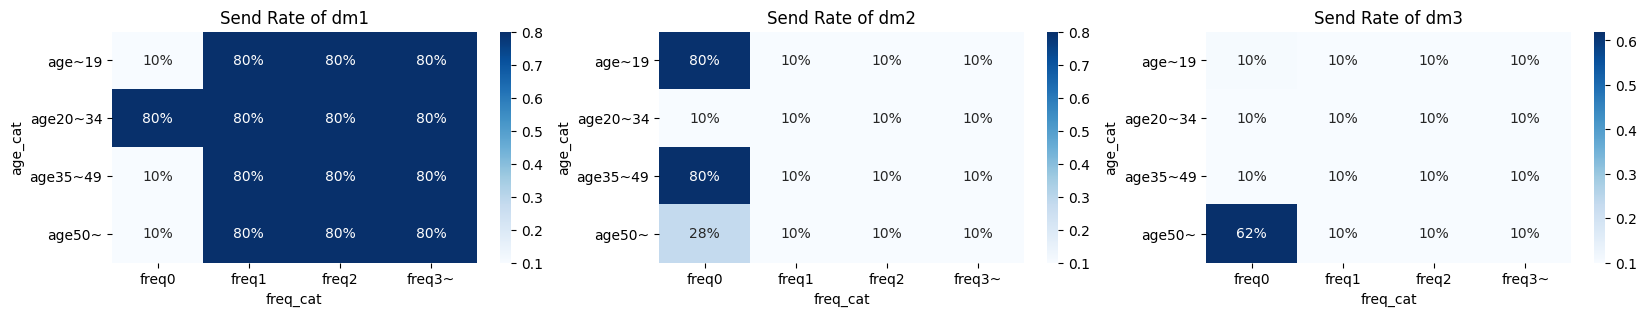

In [37]:
#各セグメントに対するそれぞれのDM送付率
fig,ax = plt.subplots(1,3, figsize=(20,3))
for i, dm in enumerate([f"send_dm{i}" for i in range(1,4)]):
    send_each_df = pd.pivot_table(data=customer_send_df, values=dm, columns="freq_cat", index="age_cat", aggfunc="mean")
    send_each_df = send_each_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
    sns.heatmap(send_each_df, annot=True, fmt=".0%", cmap="Blues", ax=ax[i])
    ax[i].set_title(f"Send Rate of {dm.replace('send_', '')}")

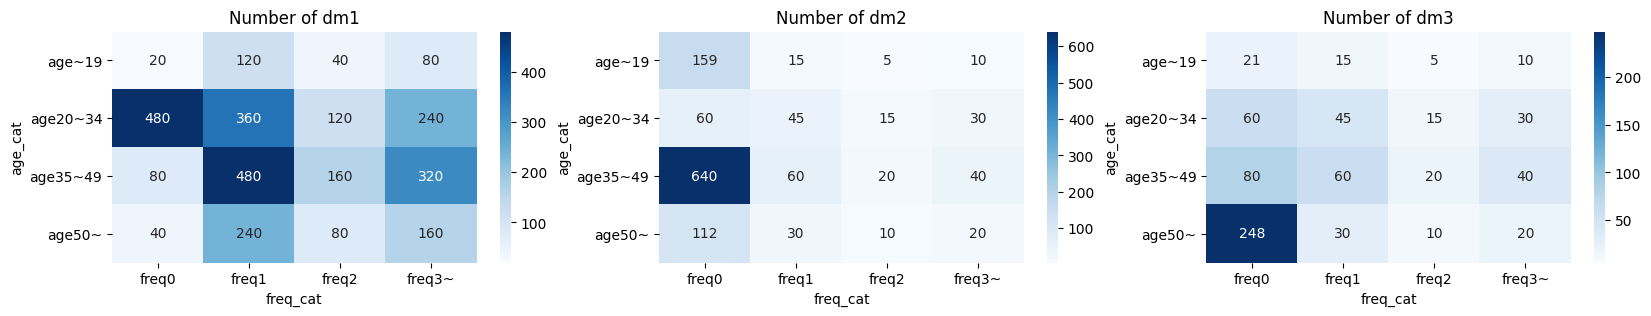

In [38]:
#各セグメントに対するそれぞれのDM送付数
fig,ax = plt.subplots(1,3, figsize=(20,3))
for i, dm in enumerate([f"send_dm{i}" for i in range(1,4)]):
    send_each_df = pd.pivot_table(data=customer_send_df, values=dm, columns="freq_cat", index="age_cat", aggfunc="sum")
    send_each_df = send_each_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
    sns.heatmap(send_each_df, annot=True, fmt=".0f", cmap="Blues", ax=ax[i])
    ax[i].set_title(f"Number of {dm.replace('send_', '')}")

#### 3-2. セグメント送付モデル
各セグメントに対して各パターンのDMをどの程度の割合で送付するかを決定するモデル

In [39]:
problem = pulp.LpProblem("DiscountCouponProblem2", sense=pulp.LpMaximize)

#### 3-2-1. 要件１：各会員に対してどのパターンのダイレクトメールを送付するかを決定
 - 決定変数：セグメント$s (\in S)$に対するダイレクトメールのパターン$m(\in M)$の送付率
   $x_{sm}\in [0, 1]$

In [40]:
xsm = {}
for s in S_list:
    for m in M_list:
        xsm[s,m] = pulp.LpVariable(name=f"xsm({s},{m})", lowBound=0, upBound=1, cat="Continuous")

In [41]:
print(xsm)

{(1, 1): xsm(1,1), (1, 2): xsm(1,2), (1, 3): xsm(1,3), (2, 1): xsm(2,1), (2, 2): xsm(2,2), (2, 3): xsm(2,3), (3, 1): xsm(3,1), (3, 2): xsm(3,2), (3, 3): xsm(3,3), (4, 1): xsm(4,1), (4, 2): xsm(4,2), (4, 3): xsm(4,3), (5, 1): xsm(5,1), (5, 2): xsm(5,2), (5, 3): xsm(5,3), (6, 1): xsm(6,1), (6, 2): xsm(6,2), (6, 3): xsm(6,3), (7, 1): xsm(7,1), (7, 2): xsm(7,2), (7, 3): xsm(7,3), (8, 1): xsm(8,1), (8, 2): xsm(8,2), (8, 3): xsm(8,3), (9, 1): xsm(9,1), (9, 2): xsm(9,2), (9, 3): xsm(9,3), (10, 1): xsm(10,1), (10, 2): xsm(10,2), (10, 3): xsm(10,3), (11, 1): xsm(11,1), (11, 2): xsm(11,2), (11, 3): xsm(11,3), (12, 1): xsm(12,1), (12, 2): xsm(12,2), (12, 3): xsm(12,3), (13, 1): xsm(13,1), (13, 2): xsm(13,2), (13, 3): xsm(13,3), (14, 1): xsm(14,1), (14, 2): xsm(14,2), (14, 3): xsm(14,3), (15, 1): xsm(15,1), (15, 2): xsm(15,2), (15, 3): xsm(15,3), (16, 1): xsm(16,1), (16, 2): xsm(16,2), (16, 3): xsm(16,3)}


#### 3-2-2. 最適化要件２：各会員に対して送付するダイレクトメールはいずれか1パターン
 - $\sum_{m \in M} x_{sm} = 1$

In [42]:
for s in S_list:
    problem += pulp.lpSum([xsm[s,m] for m in M_list]) == 1

#### 3-2-3. 最適化要件３：クーポン付与による来客増加数を最大化
 - セグメント$s (\in S)$の会員に対してパターン$m(\in M)$のDMを送付した場合の来店率（定数）$P_{sm} \in [0,1]$
 ‐ セグメント$s (\in S)$の所属数$N_{s}$
 - $\text{Max} [\sum_{s \in S} \sum_{m \in M} N_{s}(P_{sm} - P_{s1})x_{sm} ]$

In [43]:
prob_ver_df = visit_probability_df.rename(columns={"prob_dm1":1, "prob_dm2":2, "prob_dm3":3}).melt(id_vars=["segment_id"], value_vars=[1, 2, 3], var_name="dm", value_name="prob")
Psm = prob_ver_df.set_index(["segment_id", "dm"])["prob"].to_dict()

In [44]:
problem += pulp.lpSum(Ns_dict[s] *(Psm[s,m] - Psm[s,1]) * xsm[s, m] for s in S_list for m in [2,3])

#### 3-2-4. 最適化要件４：会員の予算消費期待値の合計は100万円以下
 - $\sum_{s \in S} \sum_{m \in M} C_m N_s P_{sm} x_{sm} <= 1000000$

In [45]:
problem += pulp.lpSum(Cm[m] * Ns_dict[s] * Psm[s,m] * xsm[s,m] for s in S_list for m in [2,3]) <= 1000000

#### 3-2-5. 最適化要件５：各パターンのDMをそれぞれのセグメントに属する会員数の10％以上に送付する
 - $x_{sm} >= 0.1$

In [46]:
for s in S_list:
    for m in M_list:
        problem += xsm[s,m] >= 0.1

#### 3-2-6. セグメント送付モデルの求解

In [47]:
time_start = time.time()
status = problem.solve()
time_end = time.time()

Welcome to the CBC MILP Solver 
Version: 2.9.0 
Build Date: Feb 12 2015 

command line - /home/ren-ito/anaconda3/envs/numerical-optimizaion-env/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/685907b7a9c64ed88062c28411ddca89-pulp.mps max branch printingOptions all solution /tmp/685907b7a9c64ed88062c28411ddca89-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 231 RHS
At line 297 BOUNDS
At line 346 ENDATA
Problem MODEL has 65 rows, 48 columns and 128 elements
Coin0008I MODEL read with 0 errors
Presolve 17 (-48) rows, 32 (-16) columns and 64 (-64) elements
0  Obj 229 Dual inf 981.57657 (32)
6  Obj 326.0951
Optimal - objective value 326.0951
After Postsolve, objective 326.0951, infeasibilities - dual 11.960784 (3), primal 0 (0)
Presolved model was optimal, full model needs cleaning up
0  Obj 326.0951
Optimal - objective value 326.0951
Optimal objective 326.095098 - 6 iterations time 0.002, Presolve 0.00
Option fo

In [48]:
print(f"Status: {pulp.LpStatus[status]}")
print(f"Objective: {pulp.value(problem.objective):.4}")
print(f"Spend time: {time_end - time_start} sec")

Status: Optimal
Objective: 326.1
Spend time: 0.009591817855834961 sec


計算時間を見ると、会員個別送付モデルよりも圧倒的に早い時間で解を算出できている。

#### 3-2-7. セグメント送付モデルの解の確認

In [49]:
send_dm_df = pd.DataFrame([[xsm[s,m].value() for m in M_list] for s in S_list], columns=[f"send_prob_dm{i}" for i in M_list])
seg_send_df = pd.concat([visit_probability_df[["segment_id", "age_cat", "freq_cat"]], send_dm_df], axis=1)

In [50]:
send_dm_df

,send_prob_dm1,send_prob_dm2,send_prob_dm3
0,0.1,0.800000,0.100000
1,0.8,0.100000,0.100000
2,0.8,0.100000,0.100000
3,0.8,0.100000,0.100000
4,0.8,0.100000,0.100000
5,0.8,0.100000,0.100000
6,0.8,0.100000,0.100000
7,0.8,0.100000,0.100000
8,0.1,0.800000,0.100000
9,0.8,0.100000,0.100000


In [51]:
seg_send_df

,segment_id,age_cat,freq_cat,send_prob_dm1,send_prob_dm2,send_prob_dm3
0,1,age~19,freq0,0.1,0.800000,0.100000
1,2,age~19,freq1,0.8,0.100000,0.100000
2,3,age~19,freq2,0.8,0.100000,0.100000
3,4,age~19,freq3~,0.8,0.100000,0.100000
4,5,age20~34,freq0,0.8,0.100000,0.100000
5,6,age20~34,freq1,0.8,0.100000,0.100000
6,7,age20~34,freq2,0.8,0.100000,0.100000
7,8,age20~34,freq3~,0.8,0.100000,0.100000
8,9,age35~49,freq0,0.1,0.800000,0.100000
9,10,age35~49,freq1,0.8,0.100000,0.100000


In [52]:
seg_send_df["freq_cat"].unique()

array(['freq0', 'freq1', 'freq2', 'freq3~'], dtype=object)

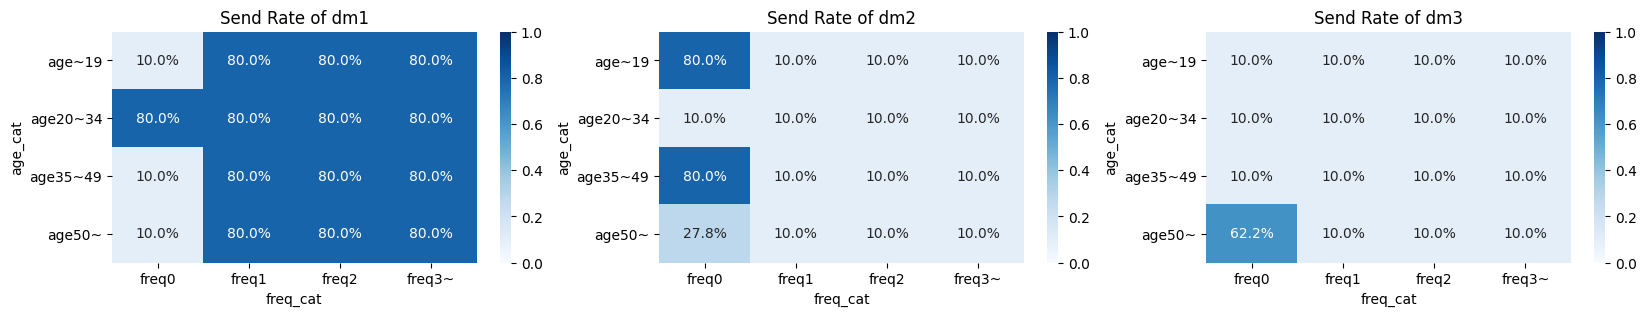

In [53]:
#各セグメントに対するそれぞれのDMの送付率
fig,ax = plt.subplots(1,3, figsize=(20,3))
for i, dm in enumerate([f"send_prob_dm{i}" for i in range(1,4)]):
    seg_send_each_df = pd.pivot_table(data=seg_send_df, values=dm, columns="freq_cat", index="age_cat", aggfunc="mean")
    seg_send_each_df = seg_send_each_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
    sns.heatmap(seg_send_each_df, annot=True, fmt=".1%", vmin=0, vmax=1, cmap="Blues", ax=ax[i])
    ax[i].set_title(f"Send Rate of {dm.replace('send_prob_', '')}")

In [54]:
seg_send_df["num_cust"] = seg_send_df["segment_id"].apply(lambda x:Ns_dict[x])
for i in M_list:
    seg_send_df[f"send_num_dm{i}"] = seg_send_df[f"send_prob_dm{i}"] * seg_send_df["num_cust"]
seg_send_df[["segment_id", "send_num_dm1", "send_num_dm2", "send_num_dm3"]]

,segment_id,send_num_dm1,send_num_dm2,send_num_dm3
0,1,20.0,160.000000,20.000000
1,2,120.0,15.000000,15.000000
2,3,40.0,5.000000,5.000000
3,4,80.0,10.000000,10.000000
4,5,480.0,60.000000,60.000000
5,6,360.0,45.000000,45.000000
6,7,120.0,15.000000,15.000000
7,8,240.0,30.000000,30.000000
8,9,80.0,640.000000,80.000000
9,10,480.0,60.000000,60.000000


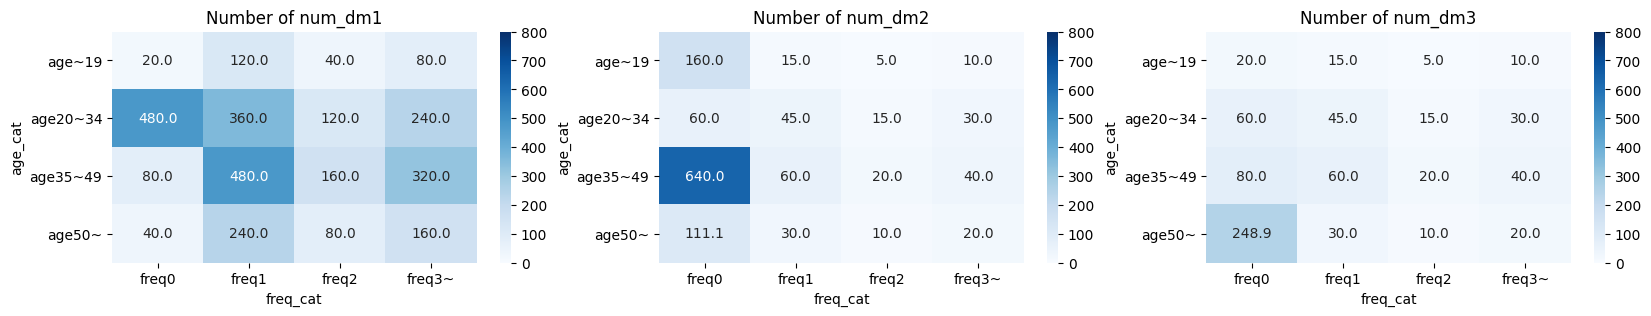

In [55]:
#各セグメントに対するそれぞれのDMの送付数
fig,ax = plt.subplots(1,3, figsize=(20,3))
for i, dm in enumerate([f"send_num_dm{i}" for i in M_list]):
    send_each_df = pd.pivot_table(data=seg_send_df, values=dm, columns="freq_cat", index="age_cat")
    send_each_df = send_each_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
    sns.heatmap(send_each_df, annot=True, fmt=".1f", cmap="Blues", vmin=0, vmax=800, ax=ax[i])
    ax[i].set_title(f"Number of {dm.replace('send_', '')}")

#### 3-3. 会員個別送付モデルとセグメント送付モデルの比較
 - 2つのモデルで解に大きな変化なし
 - 決定変数の数の違い：決定変数の数は少ない方が解きやすく、解を得る時間も少なく済む
   - 会員個別送付モデル：会員数×DMのパターン数のため、会員数が多くなれば決定変数は多くなる
   - セグメント送付モデル：セグメント数×DMのパターン数のため、セグメントの粒度が変わらなければ会員数が増えても決定変数に変化なし
 - 決定変数のタイプの違い：連続変数の方が解きやすい
   - 会員個別送付モデル：0と1をとる離散変数
   - セグメント送付モデル：決定変数が$[0,1]$の連続変数

#### 3-4. 送付率下限値最大化モデル
 - 先の2つのモデルはどちらも解に偏りがあり、クーポンの大部分は昨年度来店しなかった人に配布され、1回でも来店した人は最低限の10％しか配布していない（クーポンを配布しなくても来店するのであれば費用対効果がなく無駄と判断された）という結果になった
 - しかし、短期的には最適解かもしれないが、長期的にはあるセグメントに多く投資して他のセグメントにはほとんど投資しないことはリスクになり得る。
 - そこで、セグメント間の送付率の偏りをなくして公平に配布するよう、最適化問題を下記の通りに書き換えられる
   - 要件１：各セグメントへのDMの送付率の下限値と各会員に対してどのDMを送付するか決定
   - 要件２：各会員に対して送付するDMはいずれか1パターン
   - 要件３：各セグメントへのそれぞれのパターンのDMの送付率の下限値を最大化
   - 要件４：会員の予算消費期待値の合計は100万円以下
   - 要件５：各パターンのDMを設定した送付率の下限値以上に送付

In [56]:
problem = pulp.LpProblem(name="DiscountCouponProblem3", sense=pulp.LpMaximize)

#### 3-4-1. 最適化要件１の実装
 - 決定変数：セグメント$s (\in S)$に対するDMのパターン$m(\in M)$の送付率
    - $x_{sm} \in [0,1]$
 - 決定変数：各セグメントへのそれぞれのパターンのDMの送付率の下限値
    - $y \in [0,1]$

In [57]:
xsm = {}
#会員に対してどのDMを送付するか
for s in S_list:
    for m in M_list:
        xsm[s,m] = pulp.LpVariable(name=f"xsm({s},{m})", lowBound=0, upBound=1, cat="Continuous")
        
#各セグメントへのそれぞれのパターンのDMの送付率の下限値
y = pulp.LpVariable(name="y", lowBound=0, upBound=1, cat="Continuous")

#### 3-4-2. 最適化要件２：各会員に対して送付するダイレクトメールはいずれか1パターン
 - $\sum_{m \in M} x_{sm} = 1$

In [58]:
for s in S_list:
    problem += pulp.lpSum([xsm[s,m] for m in M_list]) == 1

#### 3-4-3. 最適化要件３：各セグメントへのそれぞれのパターンのDMの送付率の下限値を最大化
 - 目的関数：$y$

In [59]:
problem += y

#### 3-4-4. 最適化要件４：会員の予算消費期待値の合計は100万円以下
 - $\sum_{s \in S} \sum_{m \in M} C_m N_s P_{sm} x_{sm} <= 1000000$

In [60]:
problem += pulp.lpSum(Cm[m] * Ns_dict[s] * Psm[s,m] * xsm[s,m] for s in S_list for m in [2,3]) <= 1000000

#### 3-4-5. 最適化要件５：各パターンのDMを設定した送付率の下限値以上に送付
 - $x_{sm} >= y$

In [61]:
for s in S_list:
    for m in M_list:
        problem += xsm[s,m] >= y

#### 3-4-6. 送付率下限値最大化モデルの求解

In [62]:
status = problem.solve()
max_lowerbound = pulp.value(problem.objective)
print(f"Status: {pulp.LpStatus[status]}")
print(f"Objective: {max_lowerbound:.3}")

Welcome to the CBC MILP Solver 
Version: 2.9.0 
Build Date: Feb 12 2015 

command line - /home/ren-ito/anaconda3/envs/numerical-optimizaion-env/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/2992443ce76341139479a38bb7a0ba5b-pulp.mps max branch printingOptions all solution /tmp/2992443ce76341139479a38bb7a0ba5b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 248 RHS
At line 314 BOUNDS
At line 364 ENDATA
Problem MODEL has 65 rows, 49 columns and 176 elements
Coin0008I MODEL read with 0 errors
Presolve 49 (-16) rows, 33 (-16) columns and 144 (-32) elements
Perturbing problem by 0.001 % of 0.62819912 - largest nonzero change 0.00094529304 (% 0.15047666) - largest zero change 9.6171668e-05
0  Obj -0 Dual inf 0.62725282 (1)
31  Obj 0.13116342 Primal inf 0.17027776 (2)
33  Obj 0.13040049
Optimal - objective value 0.13125943
After Postsolve, objective 0.13125943, infeasibilities - dual 0 (0), primal 0 (0)
Optimal ob

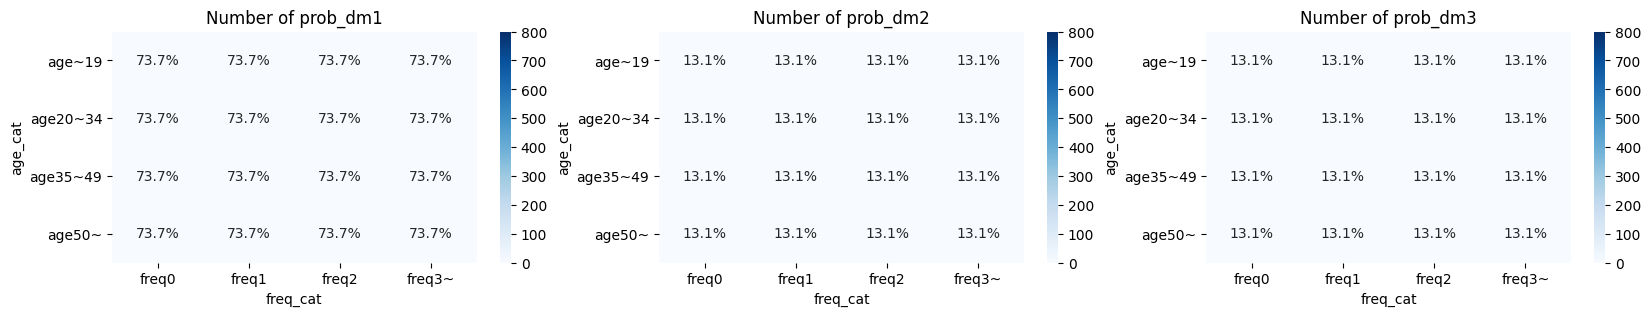

In [65]:
send_dm_df = pd.DataFrame([[xsm[s,m].value() for m in M_list] for s in S_list], columns=[f"send_prob_dm{i}" for i in M_list])
seg_send_df = pd.concat([visit_probability_df[["segment_id", "age_cat", "freq_cat"]], send_dm_df], axis=1)

#各セグメントに対するそれぞれのDMの送付数
fig,ax = plt.subplots(1,3, figsize=(20,3))
for i, dm in enumerate([f"send_prob_dm{i}" for i in M_list]):
    send_each_df = pd.pivot_table(data=seg_send_df, values=dm, columns="freq_cat", index="age_cat")
    send_each_df = send_each_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
    sns.heatmap(send_each_df, annot=True, fmt=".1%", cmap="Blues", vmin=0, vmax=800, ax=ax[i])
    ax[i].set_title(f"Number of {dm.replace('send_', '')}")

モデリングの結果を見ると、どのセグメントも偏りなくクーポンが配布されていることがわかる

送付率の下限値を10%にした場合に比べて、今回算出した13.1%を設定した場合にどのように変化するかを計算する

In [79]:
problem = pulp.LpProblem(name="DiscountCouponProblem3", sense=pulp.LpMaximize)

xsm = {}
#最適化要件１：会員に対してどのDMを送付するか
for s in S_list:
    for m in M_list:
        xsm[s,m] = pulp.LpVariable(name=f"xsm({s},{m})", lowBound=0, upBound=1, cat="Continuous")

#最適化要件２： 各会員に対して送付するダイレクトメールはいずれか1パターン       
for s in S_list:
    problem += pulp.lpSum([xsm[s,m] for m in M_list]) == 1
    
#最適化要件３：クーポン付与による来客増加数を最大化
problem += pulp.lpSum(Ns_dict[s] *(Psm[s,m] - Psm[s,1]) * xsm[s, m] for s in S_list for m in [2,3])

#最適化要件４：会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns_dict[s] * Psm[s,m] * xsm[s,m] for s in S_list for m in [2,3]) <= 1000000

#最適化要件５：各パターンのDMを設定した送付率の下限値以上に送付
for s in S_list:
    for m in M_list:
        problem += xsm[s,m] >= max_lowerbound
        
status = problem.solve()
print(f"Status: {pulp.LpStatus[status]}")
print(f"Objective: {pulp.value(problem.objective):.4}")

Welcome to the CBC MILP Solver 
Version: 2.9.0 
Build Date: Feb 12 2015 

command line - /home/ren-ito/anaconda3/envs/numerical-optimizaion-env/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/7652da6b60534d0ba7e7dd540eb62c31-pulp.mps max branch printingOptions all solution /tmp/7652da6b60534d0ba7e7dd540eb62c31-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 231 RHS
At line 297 BOUNDS
At line 346 ENDATA
Problem MODEL has 65 rows, 48 columns and 128 elements
Coin0008I MODEL read with 0 errors
Presolve 17 (-48) rows, 32 (-16) columns and 64 (-64) elements
0  Obj 300.58409 Dual inf 981.57657 (32)
1  Obj 300.58411
Optimal - objective value 300.58411
After Postsolve, objective 300.58411, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 300.5841097 - 1 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):   

この結果から、送付率の下限値を大きくすると来客増加数は326.1人から300.6人に減少することがわかる。
試しに、送付率の下限値を変更してみる。

In [80]:
problem = pulp.LpProblem(name="DiscountCouponProblem3", sense=pulp.LpMaximize)

xsm = {}
#最適化要件１：会員に対してどのDMを送付するか
for s in S_list:
    for m in M_list:
        xsm[s,m] = pulp.LpVariable(name=f"xsm({s},{m})", lowBound=0, upBound=1, cat="Continuous")

#最適化要件２： 各会員に対して送付するダイレクトメールはいずれか1パターン       
for s in S_list:
    problem += pulp.lpSum([xsm[s,m] for m in M_list]) == 1
    
#最適化要件３：クーポン付与による来客増加数を最大化
problem += pulp.lpSum(Ns_dict[s] *(Psm[s,m] - Psm[s,1]) * xsm[s, m] for s in S_list for m in [2,3])

#最適化要件４：会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns_dict[s] * Psm[s,m] * xsm[s,m] for s in S_list for m in [2,3]) <= 1000000

#最適化要件５：各パターンのDMを設定した送付率の下限値以上に送付
for s in S_list:
    for m in M_list:
        problem += xsm[s,m] >= 0.12
        
status = problem.solve()
print(f"Status: {pulp.LpStatus[status]}")
print(f"Objective: {pulp.value(problem.objective):.4}")

Welcome to the CBC MILP Solver 
Version: 2.9.0 
Build Date: Feb 12 2015 

command line - /home/ren-ito/anaconda3/envs/numerical-optimizaion-env/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/c197a70ae75447b483f4cba1e1fee629-pulp.mps max branch printingOptions all solution /tmp/c197a70ae75447b483f4cba1e1fee629-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 231 RHS
At line 297 BOUNDS
At line 346 ENDATA
Problem MODEL has 65 rows, 48 columns and 128 elements
Coin0008I MODEL read with 0 errors
Presolve 17 (-48) rows, 32 (-16) columns and 64 (-64) elements
0  Obj 274.8 Dual inf 981.57657 (32)
2  Obj 312.66
Optimal - objective value 312.66
After Postsolve, objective 312.66, infeasibilities - dual 1.7142856 (1), primal 0 (0)
Presolved model was optimal, full model needs cleaning up
0  Obj 312.66
Optimal - objective value 312.66
Optimal objective 312.66 - 2 iterations time 0.002, Presolve 0.00
Option for printingOp

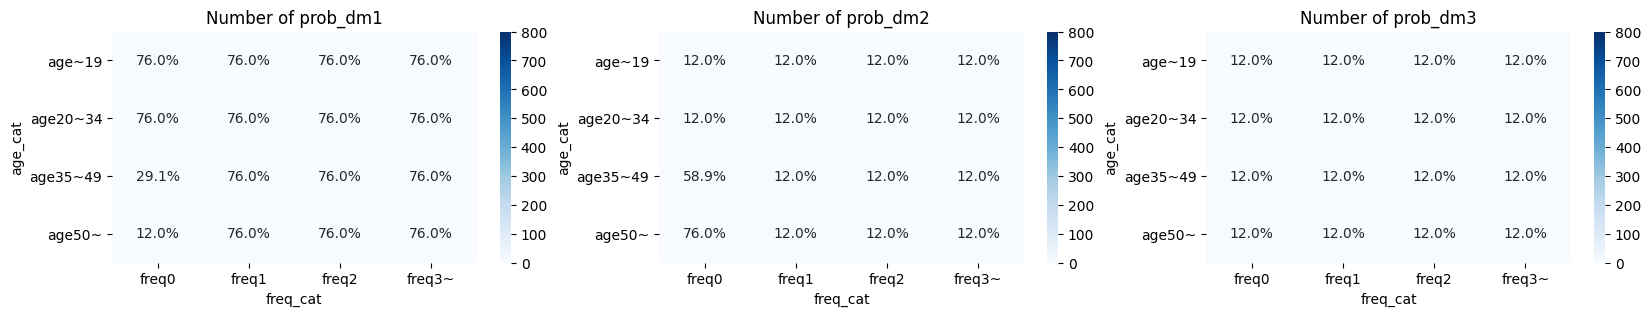

In [81]:
send_dm_df = pd.DataFrame([[xsm[s,m].value() for m in M_list] for s in S_list], columns=[f"send_prob_dm{i}" for i in M_list])
seg_send_df = pd.concat([visit_probability_df[["segment_id", "age_cat", "freq_cat"]], send_dm_df], axis=1)

#各セグメントに対するそれぞれのDMの送付数
fig,ax = plt.subplots(1,3, figsize=(20,3))
for i, dm in enumerate([f"send_prob_dm{i}" for i in M_list]):
    send_each_df = pd.pivot_table(data=seg_send_df, values=dm, columns="freq_cat", index="age_cat")
    send_each_df = send_each_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
    sns.heatmap(send_each_df, annot=True, fmt=".1%", cmap="Blues", vmin=0, vmax=800, ax=ax[i])
    ax[i].set_title(f"Number of {dm.replace('send_', '')}")

この結果からわかるように、来客増加数と公平性の間にはトレードオフの関係が成立することがわかる。

#### 3-5. 投資対効果の評価
 - DMの送付率の下限値を10%に設定した場合は、100万円の予算で326.1人の来店数増加が期待でき、来店数一人当たりの獲得費用（CPA）で換算すると、  
   $1000000/326.1 = 3066.54... \approx 3067$円で会員1人を増加させることができる
 - では、送付率の下限値を固定したうえで予算を変化させた場合にこのCPAがどのように変化するかを評価してみる
 - そのため、まずは送付率の下限値を10%と固定した場合の予算の最小値を求めてみる。
 - 次に求めた予算の最小値から10万円刻みで300万円まで予算を変化させ、その費用対効果を見てみる

In [89]:
#送付率の下限値を10％に固定した場合の予算の最小値を求める。
problem = pulp.LpProblem(name="DiscountCouponProblem4", sense=pulp.LpMaximize)

xsm = {}
#最適化要件１：会員に対してどのDMを送付するか
for s in S_list:
    for m in M_list:
        xsm[s,m] = pulp.LpVariable(name=f"xsm({s},{m})", lowBound=0, upBound=1, cat="Continuous")

#予算の値
y = pulp.LpVariable(name="y", lowBound=0, cat="Continuous")

#最適化要件２： 各会員に対して送付するダイレクトメールはいずれか1パターン       
for s in S_list:
    problem += pulp.lpSum([xsm[s,m] for m in M_list]) == 1
    
#最適化要件３：目的関数として、予算を最小化（予算の-1倍を最大化）
problem += -y

#最適化要件４：会員の予算消費期待値の合計はy円以下
problem += pulp.lpSum(Cm[m] * Ns_dict[s] * Psm[s,m] * xsm[s,m] for s in S_list for m in [2,3]) <= y

#最適化要件５：各パターンのDMを設定した送付率の下限値以上に送付
for s in S_list:
    for m in M_list:
        problem += xsm[s,m] >= 0.1
        
status = problem.solve()
print(f"Status: {pulp.LpStatus[status]}")
print(f"Objective: {pulp.value(problem.objective):.7}")

lowerbound_cost = -pulp.value(problem.objective)
print(f"Minimum value of cost: {lowerbound_cost:.7}")

Welcome to the CBC MILP Solver 
Version: 2.9.0 
Build Date: Feb 12 2015 

command line - /home/ren-ito/anaconda3/envs/numerical-optimizaion-env/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/d4098b24193d4ae8b3aaade67c4e1a27-pulp.mps max branch printingOptions all solution /tmp/d4098b24193d4ae8b3aaade67c4e1a27-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 201 RHS
At line 267 BOUNDS
At line 316 ENDATA
Problem MODEL has 65 rows, 49 columns and 129 elements
Coin0008I MODEL read with 0 errors
Presolve 17 (-48) rows, 33 (-16) columns and 65 (-64) elements
Perturbing problem by 0.001 % of 4906.6494 - largest nonzero change 0.00047811127 (% 9.7441497e-06) - largest zero change 0.00023924597
0  Obj -761850 Primal inf 2.0933195e-05 (1)
1  Obj -761850.1
Optimal - objective value -761850
After Postsolve, objective -761850, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -761850 - 1 iterations time 0.002,

このように、送付率の下限値を10%に固定した時、予算の最小値は76万1850円となる。

In [93]:
status_list = []
cost_list = []
cpa_list = []
increased_list = []

def solve_discount_coupon_problem(cost, lowerbound_send_rate):
    """
    予算（cost）と送付率の下限値（lowerbound_send_rate）を入力として最適化問題の求解と来店増加数、CPAを計算する関数
    """
    #最適化問題のインスタンス作成
    problem = pulp.LpProblem(name="DiscountCouponProblem", sense=pulp.LpMaximize)
    
    #最適化要件１：会員に対してどのDMを送付するか
    xsm = {}
    for s in S_list:
        for m in M_list:
            xsm[s,m] = pulp.LpVariable(name=f"xsm({s},{m})", lowBound=0, upBound=1, cat="Continuous")
    
    #最適化要件２： 各会員に対して送付するダイレクトメールはいずれか1パターン       
    for s in S_list:
        problem += pulp.lpSum([xsm[s,m] for m in M_list]) == 1
    
    #最適化要件３：クーポン付与による来客増加数を最大化
    problem += pulp.lpSum(Ns_dict[s] *(Psm[s,m] - Psm[s,1]) * xsm[s, m] for s in S_list for m in [2,3])
    
    #最適化要件４：会員の予算消費期待値の合計は設定したコスト以下
    problem += pulp.lpSum(Cm[m] * Ns_dict[s] * Psm[s,m] * xsm[s,m] for s in S_list for m in [2,3]) <= cost
    
    #最適化要件５：各パターンのDMを設定した送付率の下限値以上に送付
    for s in S_list:
        for m in M_list:
            problem += xsm[s,m] >= lowerbound_send_rate
            
    status = problem.solve()
    status_val = pulp.LpStatus[status]
    increased = pulp.value(problem.objective)
    cpa = cost/increased
    
    return status_val, increased, cpa
    

print(f"Status, Cost, Increased customer, CPA")
for cost in range(int(lowerbound_cost), 3000000, 100000):
    status, increased, cpa = solve_discount_coupon_problem(cost, 0.1)
    status_list.append(status)
    cost_list.append(cost)
    cpa_list.append(cpa)
    increased_list.append(increased)
    print(f"{status}, {cost}, {increased:.4}, {cpa:.5}")
    
    

Status, Cost, Increased customer, CPA
Welcome to the CBC MILP Solver 
Version: 2.9.0 
Build Date: Feb 12 2015 

command line - /home/ren-ito/anaconda3/envs/numerical-optimizaion-env/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/4dabf64dab5d4fb4a6984d4c5700f056-pulp.mps max branch printingOptions all solution /tmp/4dabf64dab5d4fb4a6984d4c5700f056-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 231 RHS
At line 297 BOUNDS
At line 346 ENDATA
Problem MODEL has 65 rows, 48 columns and 128 elements
Coin0008I MODEL read with 0 errors
Presolve 0 (-65) rows, 0 (-48) columns and 0 (-128) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 229
After Postsolve, objective 229, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 229 - 0 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock secon

In [94]:
#結果
print(f"Status, Cost, Increased customer, CPA")
for status, cost, increased, cpa in zip(status_list, cost_list, increased_list, cpa_list):
    print(f"{status}, {cost}, {increased:.4}, {cpa:.5}")

Status, Cost, Increased customer, CPA
Optimal, 761850, 229.0, 3326.9
Optimal, 861850, 273.1, 3156.3
Optimal, 961850, 311.9, 3084.0
Optimal, 1061850, 349.1, 3042.0
Optimal, 1161850, 385.8, 3011.8
Optimal, 1261850, 422.3, 2988.0
Optimal, 1361850, 458.8, 2968.0
Optimal, 1461850, 495.2, 2951.8
Optimal, 1561850, 530.5, 2944.2
Optimal, 1661850, 565.6, 2938.4
Optimal, 1761850, 600.7, 2933.2
Optimal, 1861850, 634.2, 2935.9
Optimal, 1961850, 667.3, 2940.2
Optimal, 2061850, 700.2, 2944.5
Optimal, 2161850, 732.5, 2951.4
Optimal, 2261850, 764.1, 2960.1
Optimal, 2361850, 795.5, 2969.2
Optimal, 2461850, 826.8, 2977.5
Optimal, 2561850, 858.1, 2985.3
Optimal, 2661850, 889.5, 2992.6
Optimal, 2761850, 920.8, 2999.3
Optimal, 2861850, 951.7, 3007.1
Optimal, 2961850, 981.9, 3016.4


In [105]:
print(f"Minimum of CPA: {np.min(cpa_list):.5}")
print(f"Cost: {cost_list[np.argmin(cpa_list)]}")
print(f"Increased customer: {increased_list[np.argmin(cpa_list)]:.4}")

Minimum of CPA: 2933.2
Cost: 1761850
Increased customer: 600.7


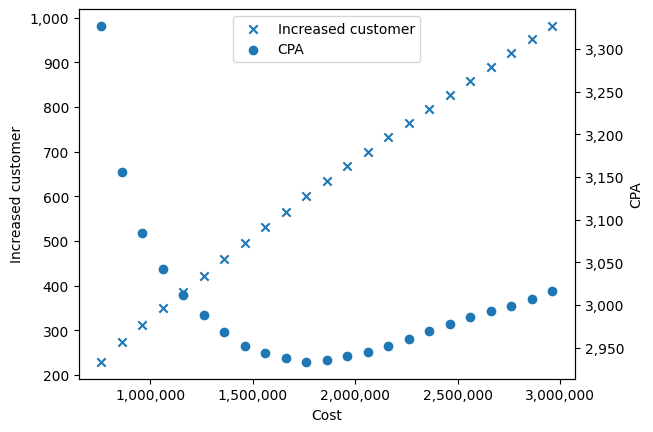

In [108]:
#結果の可視化
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(cost_list, increased_list, marker="x", label="Increased customer")
ax2.scatter(cost_list, cpa_list, label="CPA")
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:,.0f}"))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:,.0f}"))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:,.0f}"))
ax1.set_xlabel("Cost")
ax1.set_ylabel("Increased customer")
ax2.set_ylabel("CPA")
reg1, label1 = ax1.get_legend_handles_labels()
reg2, label2 = ax2.get_legend_handles_labels()
ax2.legend(reg1 + reg2, label1 + label2, loc="upper center")
plt.show()

最後に、同様にして送付率の下限値を最大化したモデルにおいて費用対効果を調べる。

In [109]:
status_list = []
cost_list = []
cpa_list = []
increased_list = []

def solve_discount_coupon_problem(cost, lowerbound_send_rate):
    """
    予算（cost）と送付率の下限値（lowerbound_send_rate）を入力として最適化問題の求解と来店増加数、CPAを計算する関数
    """
    #最適化問題のインスタンス作成
    problem = pulp.LpProblem(name="DiscountCouponProblem", sense=pulp.LpMaximize)
    
    #最適化要件１：会員に対してどのDMを送付するか
    xsm = {}
    for s in S_list:
        for m in M_list:
            xsm[s,m] = pulp.LpVariable(name=f"xsm({s},{m})", lowBound=0, upBound=1, cat="Continuous")
    
    #最適化要件２： 各会員に対して送付するダイレクトメールはいずれか1パターン       
    for s in S_list:
        problem += pulp.lpSum([xsm[s,m] for m in M_list]) == 1
    
    #最適化要件３：クーポン付与による来客増加数を最大化
    problem += pulp.lpSum(Ns_dict[s] *(Psm[s,m] - Psm[s,1]) * xsm[s, m] for s in S_list for m in [2,3])
    
    #最適化要件４：会員の予算消費期待値の合計は設定したコスト以下
    problem += pulp.lpSum(Cm[m] * Ns_dict[s] * Psm[s,m] * xsm[s,m] for s in S_list for m in [2,3]) <= cost
    
    #最適化要件５：各パターンのDMを設定した送付率の下限値以上に送付
    for s in S_list:
        for m in M_list:
            problem += xsm[s,m] >= lowerbound_send_rate
            
    status = problem.solve()
    status_val = pulp.LpStatus[status]
    increased = pulp.value(problem.objective)
    cpa = cost/increased
    
    return status_val, increased, cpa
    

print(f"Status, Cost, Increased customer, CPA")
for cost in range(int(lowerbound_cost), 3000000, 100000):
    status, increased, cpa = solve_discount_coupon_problem(cost, max_lowerbound)
    status_list.append(status)
    cost_list.append(cost)
    cpa_list.append(cpa)
    increased_list.append(increased)
    print(f"{status}, {cost}, {increased:.4}, {cpa:.5}")
    
    

Status, Cost, Increased customer, CPA
Welcome to the CBC MILP Solver 
Version: 2.9.0 
Build Date: Feb 12 2015 

command line - /home/ren-ito/anaconda3/envs/numerical-optimizaion-env/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/4710f41e99314cdaa45b07067fb852ef-pulp.mps max branch printingOptions all solution /tmp/4710f41e99314cdaa45b07067fb852ef-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 231 RHS
At line 297 BOUNDS
At line 346 ENDATA
Problem MODEL has 65 rows, 48 columns and 128 elements
Coin0008I MODEL read with 0 errors
Presolve determined that the problem was infeasible with tolerance of 1e-08
Analysis indicates model infeasible or unbounded
0  Obj -0 Primal inf 25.636488 (64) Dual inf 977.21388 (32)
36  Obj 207.05091 Primal inf 7.1755797 (15)
36  Obj 207.05091 Primal inf 7.1755797 (15)
Primal infeasible - objective value 207.05091
PrimalInfeasible objective 207.0509117 - 36 iterations time 0.002

R

In [110]:
#結果
print(f"Status, Cost, Increased customer, CPA")
for status, cost, increased, cpa in zip(status_list, cost_list, increased_list, cpa_list):
    print(f"{status}, {cost}, {increased:.4}, {cpa:.5}")

Status, Cost, Increased customer, CPA
Infeasible, 761850, 207.1, 3679.5
Infeasible, 861850, 242.1, 3559.8
Infeasible, 961850, 283.0, 3399.0
Optimal, 1061850, 328.1, 3236.1
Optimal, 1161850, 368.1, 3156.1
Optimal, 1261850, 405.3, 3113.3
Optimal, 1361850, 442.0, 3081.2
Optimal, 1461850, 478.5, 3054.9
Optimal, 1561850, 515.0, 3032.5
Optimal, 1661850, 550.8, 3017.2
Optimal, 1761850, 585.9, 3007.1
Optimal, 1861850, 621.0, 2998.2
Optimal, 1961850, 654.5, 2997.3
Optimal, 2061850, 687.6, 2998.7
Optimal, 2161850, 720.5, 3000.6
Optimal, 2261850, 752.4, 3006.4
Optimal, 2361850, 783.7, 3013.7
Optimal, 2461850, 815.0, 3020.5
Optimal, 2561850, 846.4, 3026.8
Optimal, 2661850, 877.7, 3032.7
Optimal, 2761850, 909.0, 3038.2
Optimal, 2861850, 939.5, 3046.1
Optimal, 2961850, 969.7, 3054.3


In [111]:
print(f"Minimum of CPA: {np.min(cpa_list):.5}")
print(f"Cost: {cost_list[np.argmin(cpa_list)]}")
print(f"Increased customer: {increased_list[np.argmin(cpa_list)]:.4}")

Minimum of CPA: 2997.3
Cost: 1961850
Increased customer: 654.5


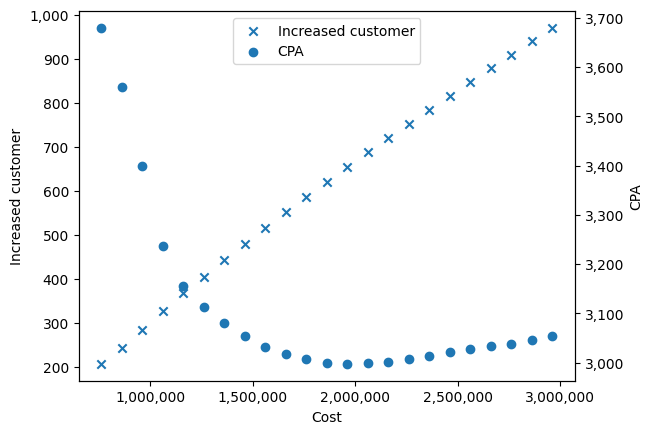

In [112]:
#結果の可視化
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(cost_list, increased_list, marker="x", label="Increased customer")
ax2.scatter(cost_list, cpa_list, label="CPA")
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:,.0f}"))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:,.0f}"))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:,.0f}"))
ax1.set_xlabel("Cost")
ax1.set_ylabel("Increased customer")
ax2.set_ylabel("CPA")
reg1, label1 = ax1.get_legend_handles_labels()
reg2, label2 = ax2.get_legend_handles_labels()
ax2.legend(reg1 + reg2, label1 + label2, loc="upper center")
plt.show()